In [8]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 26.6 MB/s eta 0:00:0000:010:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.7/824.7 kB 33.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# DL libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

# Time Series Analysis libraries
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller (ADF) Test
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Ignore warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
df = pd.read_csv('Time-Series_data.txt', delimiter=',')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [11]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [13]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [14]:
print(df.isnull().sum())

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [15]:
df.shape

(9357, 15)

In [16]:
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
dtype: int64

In [17]:
df.duplicated().sum()

np.int64(0)

Count of negative values in each column:
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 379
RH                366
AH                366
dtype: int64


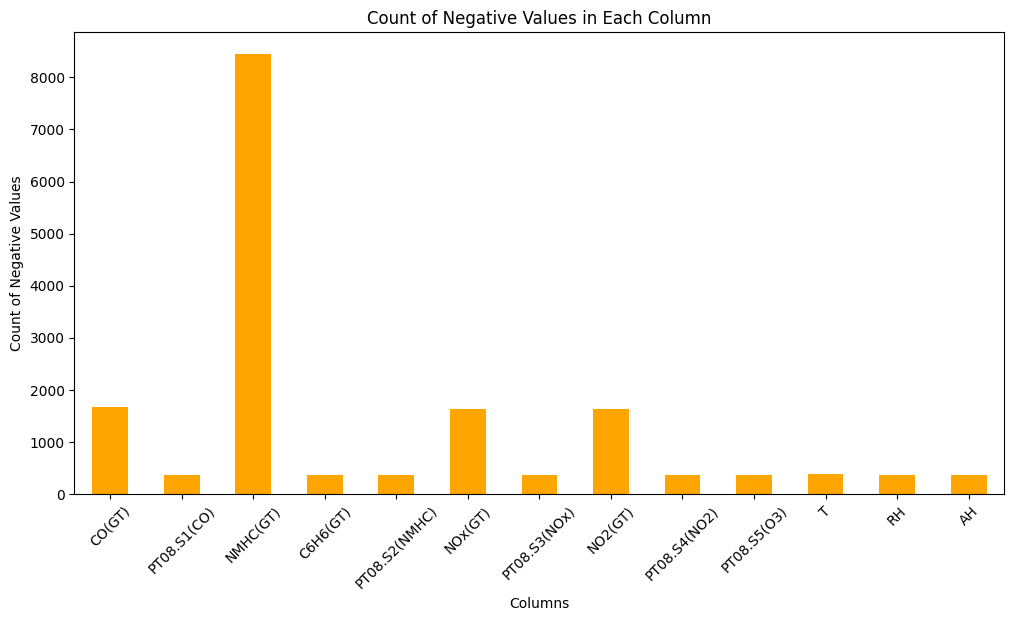

In [18]:
# Step 1: Ensure numeric columns
numeric_columns = df.select_dtypes(include=['number'])  # Select only numeric columns

# Step 2: Check for negative values in each column
negative_counts = (numeric_columns < 0).sum()

# Step 3: Filter only columns with negative values
negative_counts = negative_counts[negative_counts > 0]

# Step 4: Display counts of negative values
print("Count of negative values in each column:")
print(negative_counts)

# Step 5: Visualization
import matplotlib.pyplot as plt

if not negative_counts.empty:
    plt.figure(figsize=(12, 6))
    negative_counts.plot(kind='bar', color='orange')
    plt.title('Count of Negative Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('Count of Negative Values')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No negative values found in numeric columns.")

In [19]:
#Converts the Time Date value to a string, last 4 characters of the string, representing the year.
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [20]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,Month,Day
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004,3,10
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004,3,10
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004,3,10
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004,3,10
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004,3,10


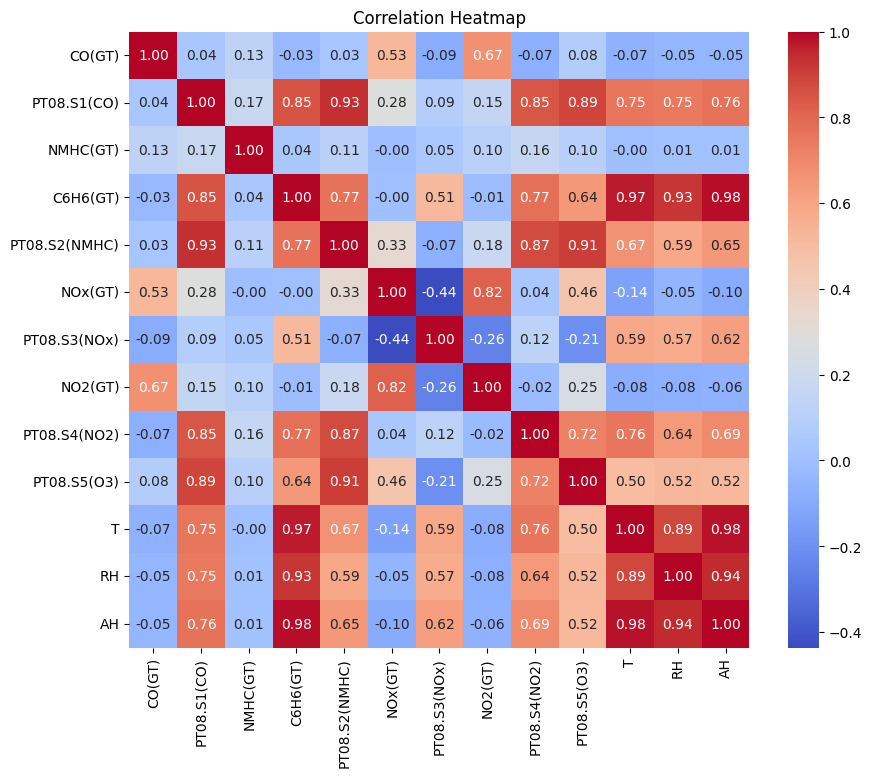

In [21]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Project Workflow</h2>

---
### **Deliverables**:
1. **Forecasting Models**:
   - Trained models for `CO(GT)` and `NO₂(GT)`.
2. **Forecast Visualization**:
   - Plots showing historical trends and future predictions.
3. **Evaluation Report**:
   - Metrics and comparison of different forecasting models.
4. **Insights and Recommendations**:
   - Suggestions for mitigating high levels of these gases based on predictions.


### **1. Data Preprocessing**
---
- **Date-Time Parsing**:
  - Combine the `Date` and `Time` columns into a single `datetime` column.
  - Set the `datetime` column as the index of the dataset.
- **Resampling**:
  - Aggregate the data into meaningful time intervals (e.g., hourly or daily averages).
- **Handle Missing Values**:
  - Use interpolation, mean, or advanced imputation techniques to fill missing data for `CO(GT)` and `NO₂(GT)`.
- **Outlier Detection**:
  - Remove or cap extreme values in `CO(GT)` and `NO₂(GT)` using statistical thresholds.

In [22]:
# Date-Time Parsing
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.drop(columns=['Date', 'Time'], inplace=True)
df.set_index('datetime', inplace=True)

In [23]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,Month,Day
datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004,3,10
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004,3,10
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004,3,10
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004,3,10
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004,3,10


In [24]:
# Resample the data daily basis a. 
daily_data = df.resample('D').mean()
print(daily_data.head())

               CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                   
2004-03-10   1.966667  1316.500000   86.500000   8.450000     912.333333   
2004-03-11  -6.187500  1244.166667  104.500000   7.979167     851.958333   
2004-03-12 -14.095833  1281.666667  141.500000  12.129167    1008.291667   
2004-03-13  -5.750000  1330.666667  139.250000  10.916667     992.833333   
2004-03-14  -5.966667  1361.125000  116.958333   9.637500     943.916667   

               NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
datetime                                                                      
2004-03-10  132.000000   1167.333333  108.833333   1545.500000  1096.000000   
2004-03-11  130.041667   1277.250000   87.375000   1522.833333   885.250000   
2004-03-12  142.583333   1101.875000   89.916667   1627.291667  1084.375000   
2004-03-13  168.416667    993.208333  105.583333   1595.791667  1245.916

### outliers 

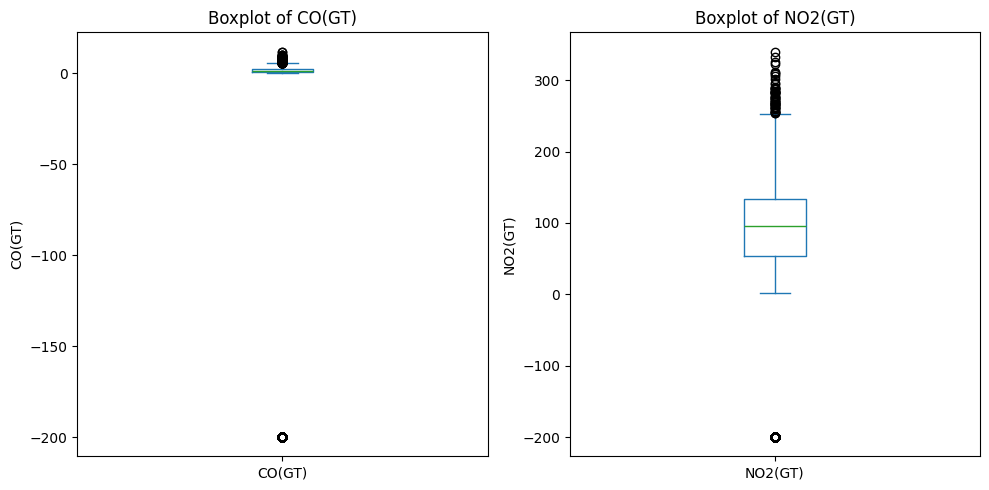

In [25]:
import matplotlib.pyplot as plt

# CO(GT) Boxplots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='box', title='Boxplot of CO(GT)')
plt.ylabel('CO(GT)')

# NO2(GT) Boxplots
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='box', title='Boxplot of NO2(GT)')
plt.ylabel('NO2(GT)')

plt.tight_layout()
plt.show()

In [26]:
# Function to cap outliers based on IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Cap outliers for CO(GT) and NO2(GT)
df = cap_outliers_iqr(df, 'CO(GT)')
df = cap_outliers_iqr(df, 'NO2(GT)')

In [27]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for CO(GT) and NO2(GT)
df = remove_outliers_iqr(df, 'CO(GT)')
df = remove_outliers_iqr(df, 'NO2(GT)')

# Reset index after removing outliers
df.reset_index(drop=True, inplace=True)

In [28]:
from scipy.stats import zscore

# Z-Score Method
def detect_outliers_zscore(data, threshold=3):
    outliers = {}
    for col in data.select_dtypes(include=np.number):  # Numeric columns only
        z_scores = zscore(data[col].dropna())
        outliers[col] = data[col][np.abs(z_scores) > threshold]
    return outliers

# IQR Method
def detect_outliers_iqr(data):
    outliers = {}
    for col in data.select_dtypes(include=np.number):  # Numeric columns only
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

# Detect outliers using both methods
zscore_outliers = detect_outliers_zscore(df)
iqr_outliers = detect_outliers_iqr(df)

# Print results
print("Outliers detected using Z-Score:")
for col, outlier_values in zscore_outliers.items():
    print(f"{col}: {len(outlier_values)} outliers")

print("\nOutliers detected using IQR:")
for col, outlier_values in iqr_outliers.items():
    print(f"{col}: {len(outlier_values)} outliers")

Outliers detected using Z-Score:
CO(GT): 0 outliers
PT08.S1(CO): 367 outliers
NMHC(GT): 270 outliers
C6H6(GT): 366 outliers
PT08.S2(NMHC): 375 outliers
NOx(GT): 110 outliers
PT08.S3(NOx): 422 outliers
NO2(GT): 0 outliers
PT08.S4(NO2): 366 outliers
PT08.S5(O3): 19 outliers
T: 366 outliers
RH: 366 outliers
AH: 366 outliers
Year: 0 outliers
Month: 0 outliers
Day: 0 outliers

Outliers detected using IQR:
CO(GT): 0 outliers
PT08.S1(CO): 484 outliers
NMHC(GT): 914 outliers
C6H6(GT): 606 outliers
PT08.S2(NMHC): 426 outliers
NOx(GT): 509 outliers
PT08.S3(NOx): 602 outliers
NO2(GT): 0 outliers
PT08.S4(NO2): 450 outliers
PT08.S5(O3): 458 outliers
T: 368 outliers
RH: 366 outliers
AH: 367 outliers
Year: 2247 outliers
Month: 0 outliers
Day: 0 outliers


In [29]:
# Remove outliers using Z-score method
def remove_outliers_zscore(data, threshold=3):
    for col in data.select_dtypes(include=np.number):
        z_scores = zscore(data[col].dropna())
        data = data[np.abs(z_scores) <= threshold]
    return data

# Remove outliers using IQR method
def remove_outliers_iqr(data):
    for col in data.select_dtypes(include=np.number):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Example usage
df_cleaned_zscore = remove_outliers_zscore(df.copy())
df_cleaned_iqr = remove_outliers_iqr(df.copy())

print("Dataset after removing outliers (Z-score):", df_cleaned_zscore.shape)
print("Dataset after removing outliers (IQR):", df_cleaned_iqr.shape)

Dataset after removing outliers (Z-score): (8391, 16)
Dataset after removing outliers (IQR): (7262, 16)


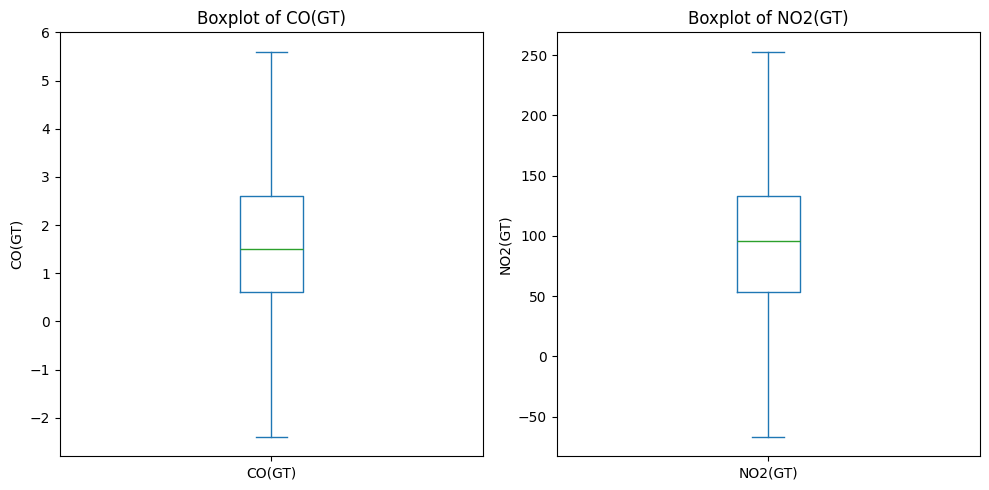

In [30]:
import matplotlib.pyplot as plt

# CO(GT) Boxplots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='box', title='Boxplot of CO(GT)')
plt.ylabel('CO(GT)')

# NO2(GT) Boxplots
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='box', title='Boxplot of NO2(GT)')
plt.ylabel('NO2(GT)')

plt.tight_layout()
plt.show()

Identified Outliers:
Series([], Name: CO(GT), dtype: float64)


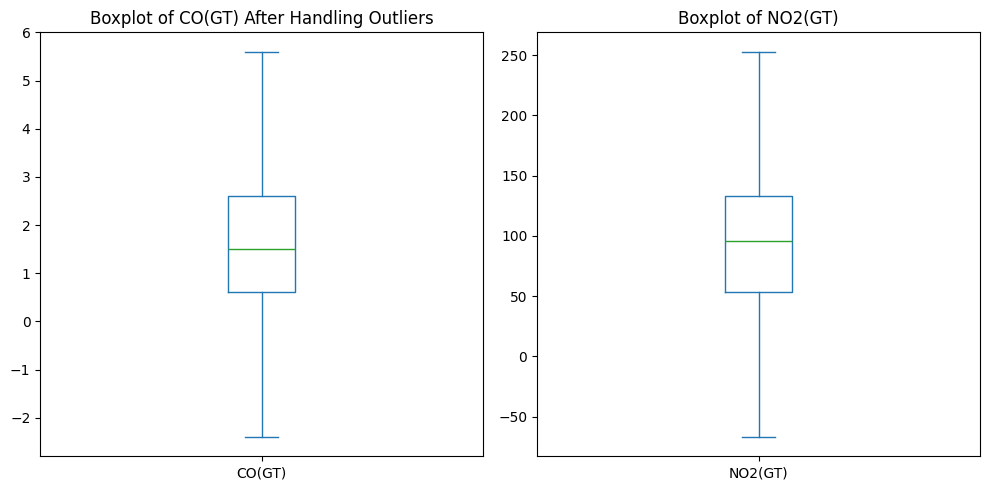

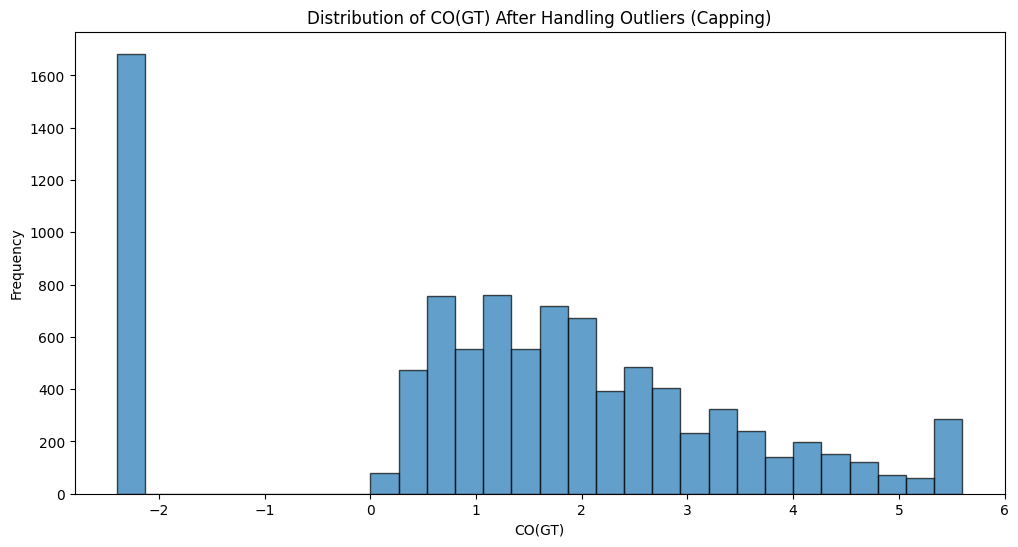

In [31]:
# Adjust Z-Score Threshold for Outlier Detection
z_threshold = 3.5  
df['CO(GT)_zscore'] = zscore(df['CO(GT)'])

# Identify Outliers
outliers = df.loc[abs(df['CO(GT)_zscore']) > z_threshold, 'CO(GT)']
print(f"Identified Outliers:\n{outliers}")

# Cap Outliers Instead of Replacing with Median
Q1 = df['CO(GT)'].quantile(0.25)
Q3 = df['CO(GT)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap values at lower and upper bounds
df['CO(GT)'] = df['CO(GT)'].clip(lower=lower_bound, upper=upper_bound)

# Drop the temporary Z-score column
df.drop(columns=['CO(GT)_zscore'], inplace=True)

# Visualize the Results
# Boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='box', title='Boxplot of CO(GT) After Handling Outliers')
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='box', title='Boxplot of NO2(GT)')
plt.tight_layout()
plt.show()

# Histogram for Distribution Check
plt.figure(figsize=(12, 6))
plt.hist(df['CO(GT)'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of CO(GT) After Handling Outliers (Capping)')
plt.xlabel('CO(GT)')
plt.ylabel('Frequency')
plt.show()

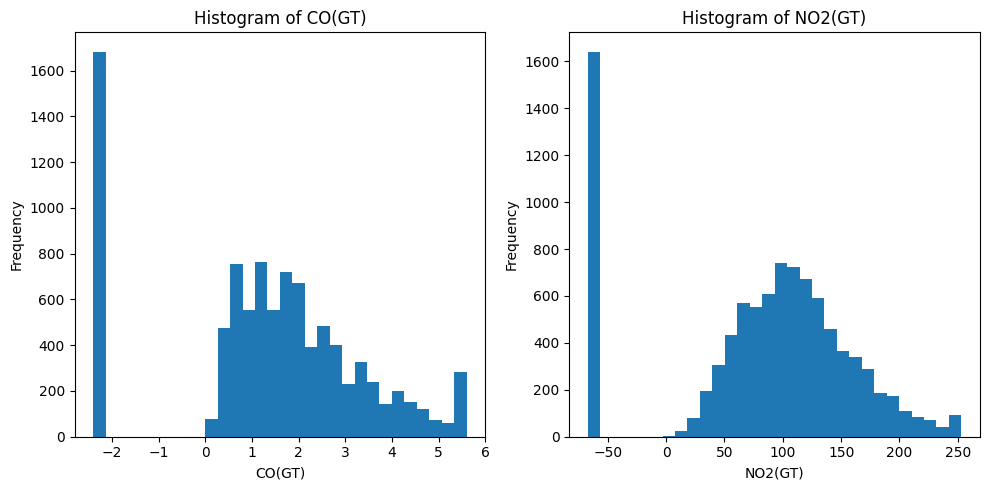

In [32]:
# CO(GT) and NO2(GT) Histplolt
plt.figure(figsize=(10, 5))

# CO(GT) Histplolt
plt.subplot(1, 2, 1)
df['CO(GT)'].plot(kind='hist', bins=30, title='Histogram of CO(GT)')
plt.xlabel('CO(GT)')

# NO2(GT) Histplolt
plt.subplot(1, 2, 2)
df['NO2(GT)'].plot(kind='hist', bins=30, title='Histogram of NO2(GT)')
plt.xlabel('NO2(GT)')

plt.tight_layout()
plt.show()

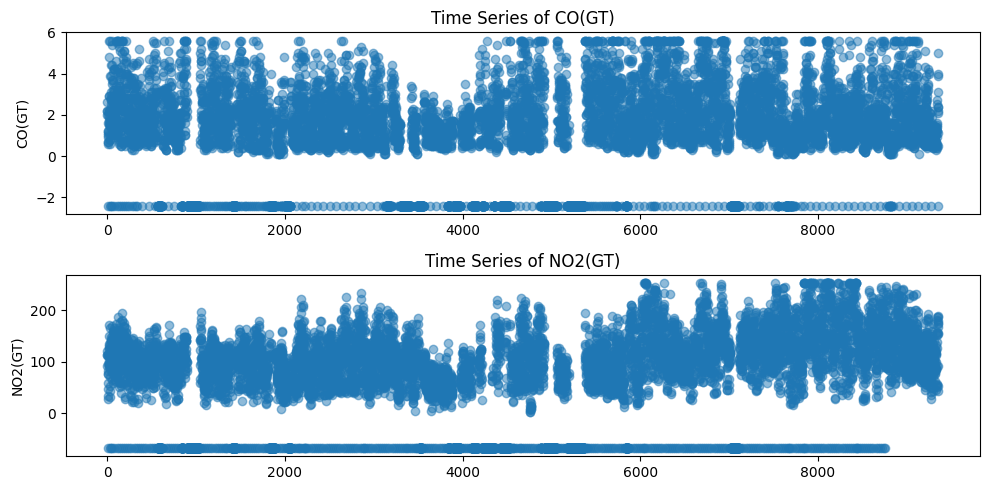

In [33]:
plt.figure(figsize=(10, 5))

# CO(GT) Plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['CO(GT)'], 'o', alpha=0.5)
plt.title('Time Series of CO(GT)')
plt.ylabel('CO(GT)')

# NO2(GT) Plot
plt.subplot(2, 1, 2)
plt.plot(df.index, df['NO2(GT)'], 'o', alpha=0.5)
plt.title('Time Series of NO2(GT)')
plt.ylabel('NO2(GT)')

plt.tight_layout()
plt.show()

In [34]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'Year', 'Month', 'Day'],
      dtype='object')

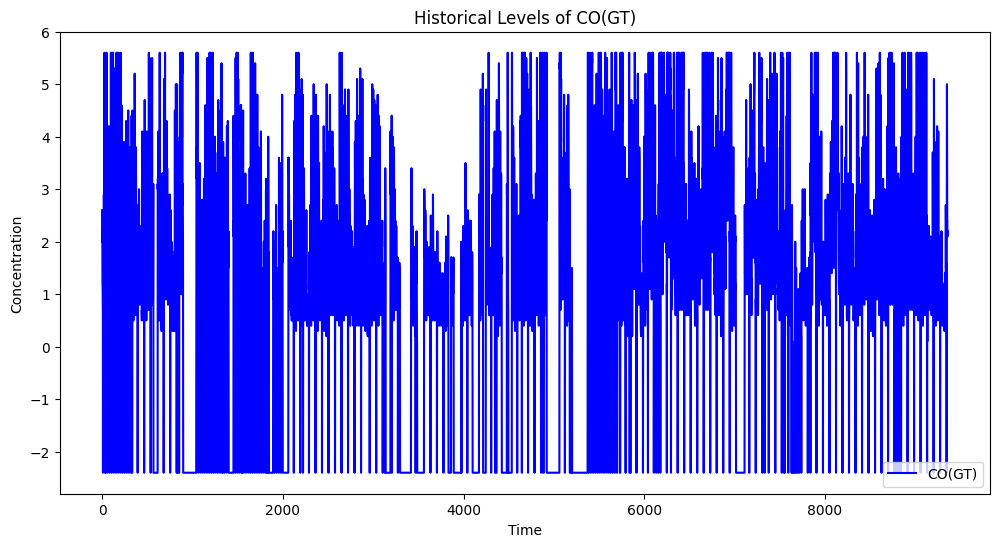

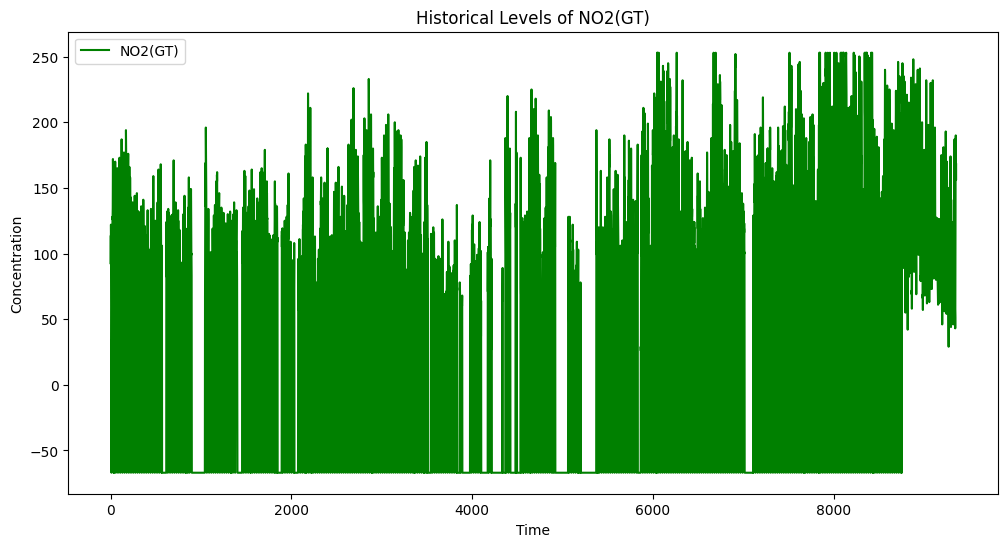

In [35]:
import matplotlib.pyplot as plt

# Plotting CO(GT) historical data
plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'], label='CO(GT)', color='blue')
plt.title('Historical Levels of CO(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Plotting NO2(GT) historical data
plt.figure(figsize=(12, 6))
plt.plot(df['NO2(GT)'], label='NO2(GT)', color='green')
plt.title('Historical Levels of NO2(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">2. Exploratory Data Analysis (EDA)</h2>

  ---
- **Trend Analysis**:
  - Visualize the long-term trends of `CO(GT)` and `NO₂(GT)`.
- **Seasonality**:
  - Identify seasonal patterns (e.g., daily or yearly fluctuations).
- **Correlation Analysis**:
  - Explore relationships between `CO(GT)`, `NO₂(GT)`, and other features (e.g., temperature or humidity).

# Performing trend analysis using the same dataset

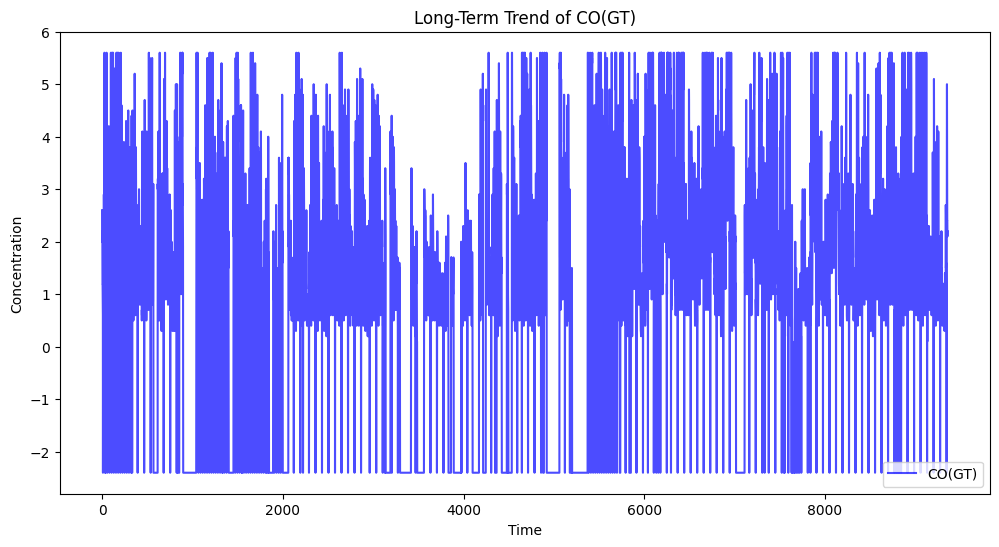

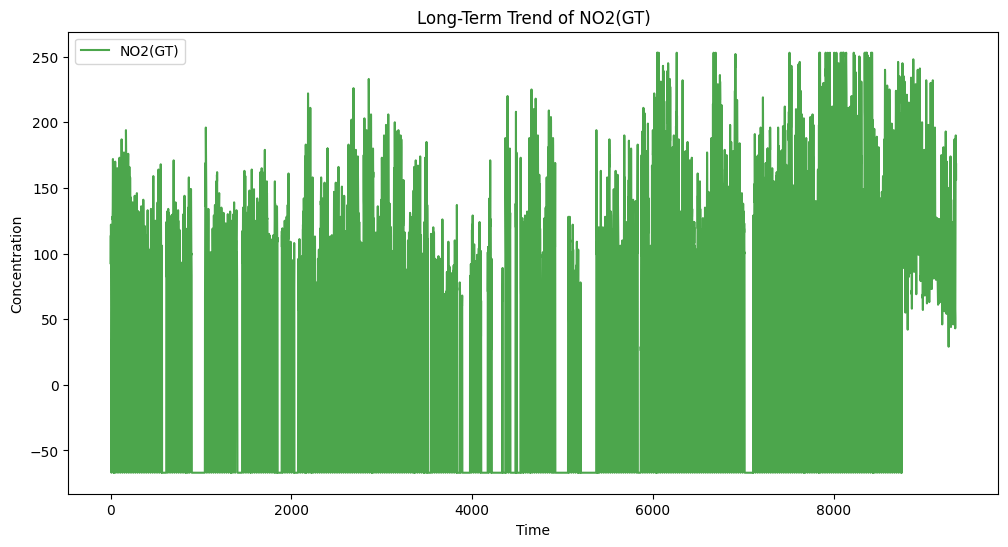

In [36]:
# Plot for CO(GT)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO(GT)'], label='CO(GT)', color='blue', alpha=0.7)
plt.title('Long-Term Trend of CO(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Plot for NO2(GT)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['NO2(GT)'], label='NO2(GT)', color='green', alpha=0.7)
plt.title('Long-Term Trend of NO2(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

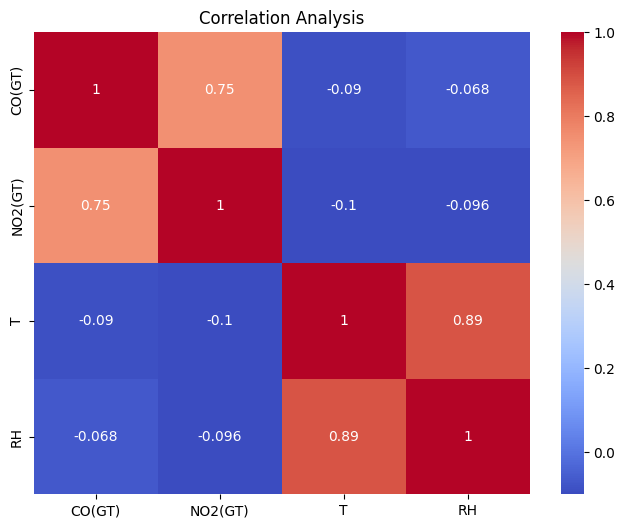

In [37]:
# Correlation between features
correlation = df[['CO(GT)', 'NO2(GT)', 'T', 'RH']].corr()

# Visualize correlation as a heatmap
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis')
plt.show()

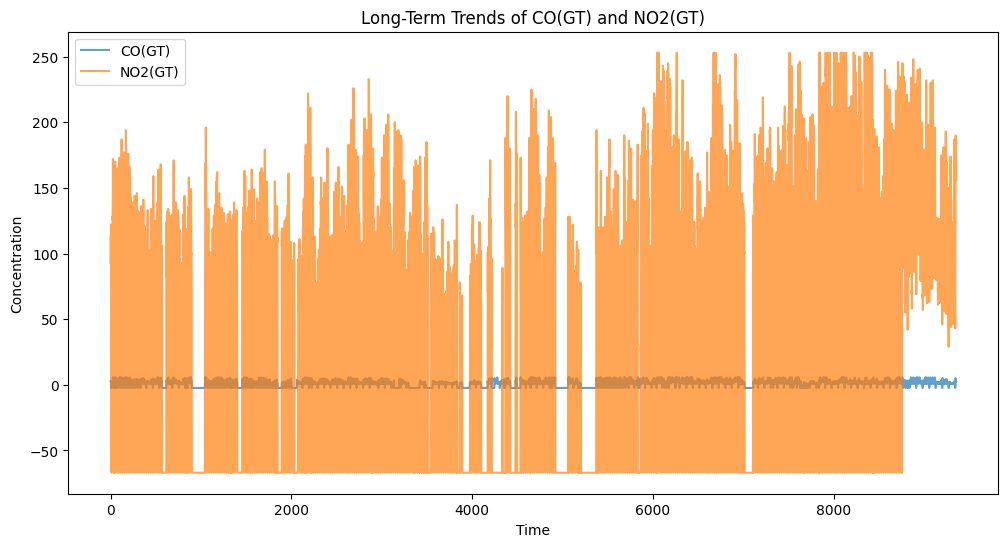

In [38]:
# long-term trends Analysis
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CO(GT)'], label='CO(GT)', alpha=0.7)
plt.plot(df.index, df['NO2(GT)'], label='NO2(GT)', alpha=0.7)
plt.title('Long-Term Trends of CO(GT) and NO2(GT)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

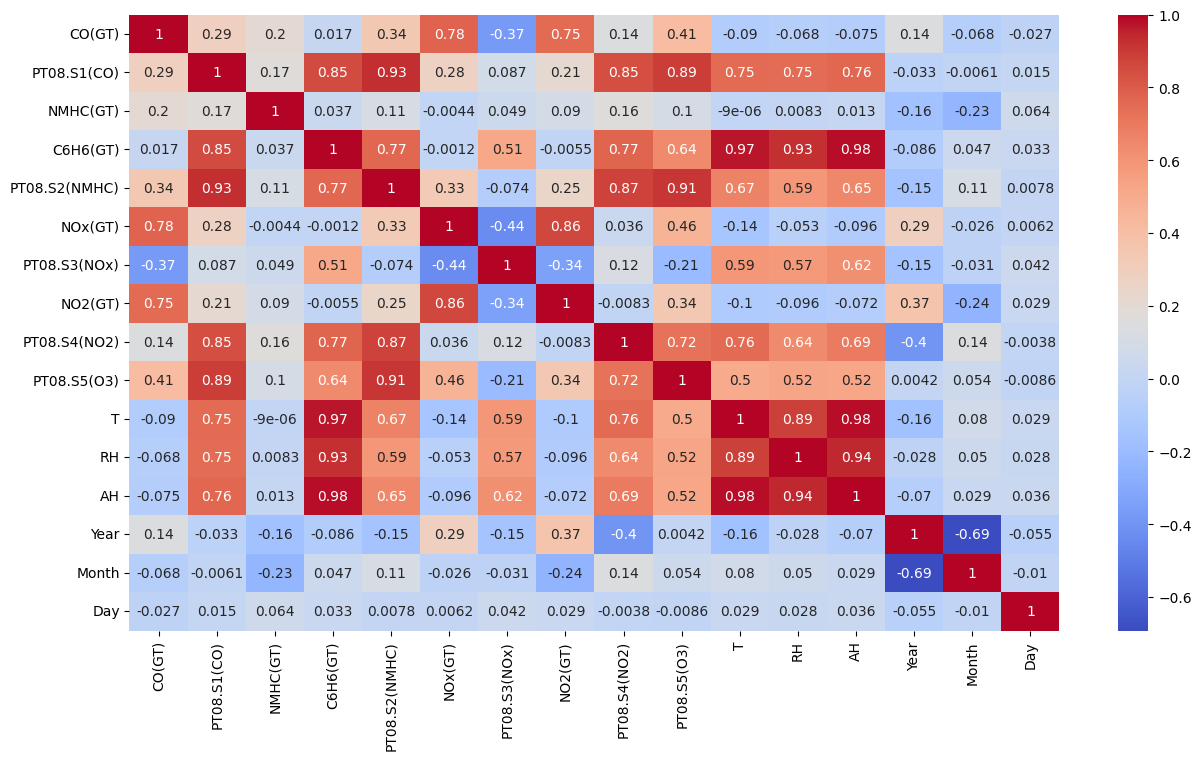

In [39]:
plt.figure(figsize=(15, 8))
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

         CO(GT)    NO2(GT)
Month                     
1      1.305579  81.331303


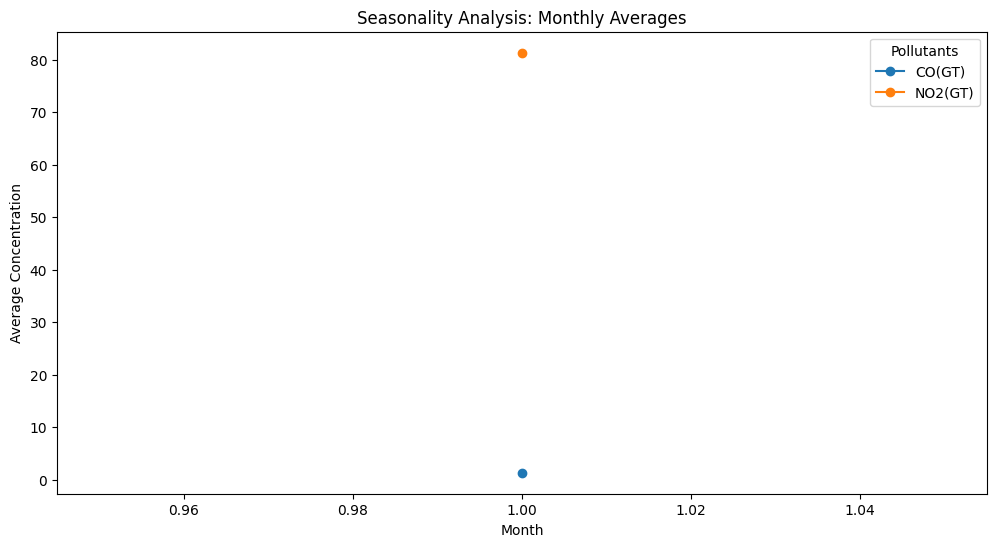

In [40]:
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Extract the 'month' from the index
df['Month'] = df.index.month

# Group by month and calculate the average
monthly_avg = df.groupby('Month')[['CO(GT)', 'NO2(GT)']].mean()
print(monthly_avg)

# Step 4: Plot the seasonal trends
monthly_avg.plot(figsize=(12, 6), marker='o')
plt.title('Seasonality Analysis: Monthly Averages')
plt.xlabel('Month')
plt.ylabel('Average Concentration')
plt.legend(title='Pollutants')
plt.show()

        CO(GT)    NO2(GT)
Hour                     
0     1.305579  81.331303


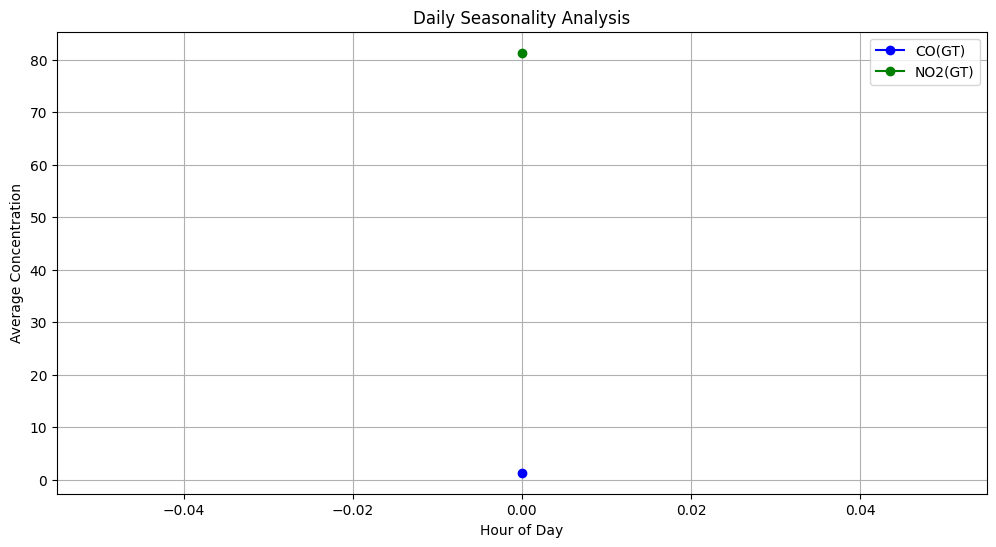

In [41]:
# Convert the index to datetime format
df.index = pd.to_datetime(df.index)

# Create the 'Hour' column
df['Hour'] = df.index.hour

# Calculate hourly averages
hourly_avg = df.groupby('Hour')[['CO(GT)', 'NO2(GT)']].mean()

# Display the hourly averages
print(hourly_avg)

# Step 5: Plot hourly averages
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg['CO(GT)'], label='CO(GT)', marker='o', color='blue')
plt.plot(hourly_avg.index, hourly_avg['NO2(GT)'], label='NO2(GT)', marker='o', color='green')
plt.title('Daily Seasonality Analysis')
plt.xlabel('Hour of Day')
plt.ylabel('Average Concentration')
plt.legend()
plt.grid()
plt.show()

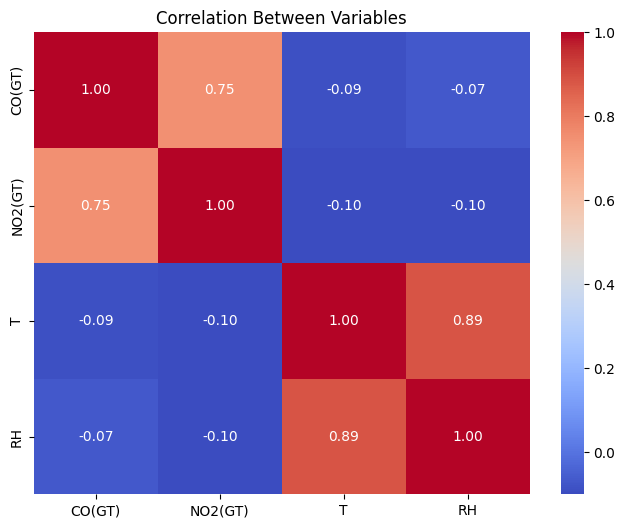

In [42]:
import seaborn as sns

# correlation matrix
correlation_matrix = df[['CO(GT)', 'NO2(GT)', 'T', 'RH']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Variables')
plt.show()

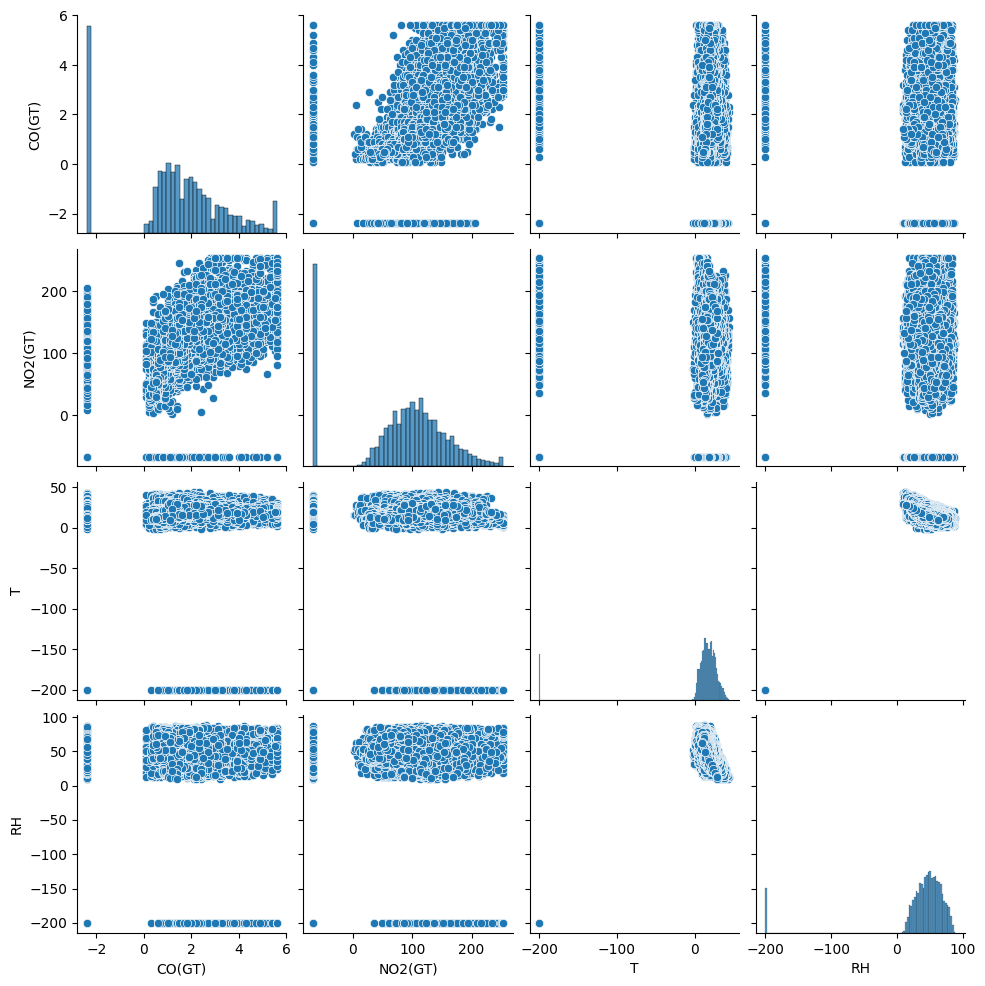

In [43]:
# Pair plot to visualize relationships
sns.pairplot(df[['CO(GT)', 'NO2(GT)', 'T', 'RH']])
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">3. Feature Engineering</h2>
    
  ---
- Create lag features for `CO(GT)` and `NO₂(GT)` to incorporate historical values.
- Add time-based features (e.g., hour of the day, day of the week, month).
- Include environmental factors (`T`, `RH`, `AH`) as predictors.

In [44]:
# Create lag features for CO(GT) and NO2(GT)
df['CO_lag1'] = df['CO(GT)'].shift(1)
df['CO_lag2'] = df['CO(GT)'].shift(2)

df['NO2_lag1'] = df['NO2(GT)'].shift(1)
df['NO2_lag2'] = df['NO2(GT)'].shift(2)

# Drop rows with NaN values caused by lagging
df = df.dropna()

In [45]:
# Extract time-based features using .loc to modify the original DataFrame
df.loc[:, 'hour'] = df.index.hour
df.loc[:, 'day_of_week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
df.loc[:, 'month'] = df.index.month

In [46]:
# Ensure predictors are present
predictors = ['T', 'RH', 'AH', 'CO_lag1', 'CO_lag2', 'NO2_lag1', 'NO2_lag2', 'hour', 'day_of_week', 'month']

In [47]:
# Define X (features) and y (target)
X = df[predictors]
y_CO = df['CO(GT)']
y_NO2 = df['NO2(GT)']

# Check the final feature set
print(X.head())

                                  T    RH      AH  CO_lag1  CO_lag2  NO2_lag1  \
1970-01-01 00:00:00.000000002  11.9  54.0  0.7502      2.0      2.6      92.0   
1970-01-01 00:00:00.000000003  11.0  60.0  0.7867      2.2      2.0     114.0   
1970-01-01 00:00:00.000000004  11.2  59.6  0.7888      2.2      2.2     122.0   
1970-01-01 00:00:00.000000005  11.2  59.2  0.7848      1.6      2.2     116.0   
1970-01-01 00:00:00.000000006  11.3  56.8  0.7603      1.2      1.6      96.0   

                               NO2_lag2  hour  day_of_week  month  
1970-01-01 00:00:00.000000002     113.0     0            3      1  
1970-01-01 00:00:00.000000003      92.0     0            3      1  
1970-01-01 00:00:00.000000004     114.0     0            3      1  
1970-01-01 00:00:00.000000005     122.0     0            3      1  
1970-01-01 00:00:00.000000006     116.0     0            3      1  


In [48]:
# Display the first few rows to check lag features
print(df[['CO(GT)', 'CO_lag1', 'CO_lag2', 'NO2(GT)', 'NO2_lag1', 'NO2_lag2']].head(10))

                               CO(GT)  CO_lag1  CO_lag2  NO2(GT)  NO2_lag1  \
1970-01-01 00:00:00.000000002     2.2      2.0      2.6      114      92.0   
1970-01-01 00:00:00.000000003     2.2      2.2      2.0      122     114.0   
1970-01-01 00:00:00.000000004     1.6      2.2      2.2      116     122.0   
1970-01-01 00:00:00.000000005     1.2      1.6      2.2       96     116.0   
1970-01-01 00:00:00.000000006     1.2      1.2      1.6       77      96.0   
1970-01-01 00:00:00.000000007     1.0      1.2      1.2       76      77.0   
1970-01-01 00:00:00.000000008     0.9      1.0      1.2       60      76.0   
1970-01-01 00:00:00.000000009     0.6      0.9      1.0      -67      60.0   
1970-01-01 00:00:00.000000010    -2.4      0.6      0.9       34     -67.0   
1970-01-01 00:00:00.000000011     0.7     -2.4      0.6       28      34.0   

                               NO2_lag2  
1970-01-01 00:00:00.000000002     113.0  
1970-01-01 00:00:00.000000003      92.0  
1970-01-01 00:0

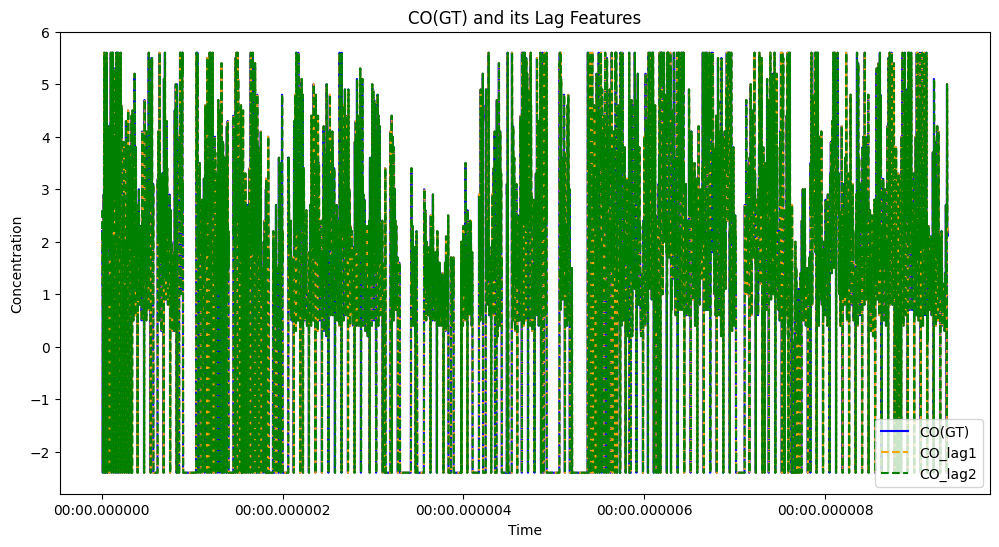

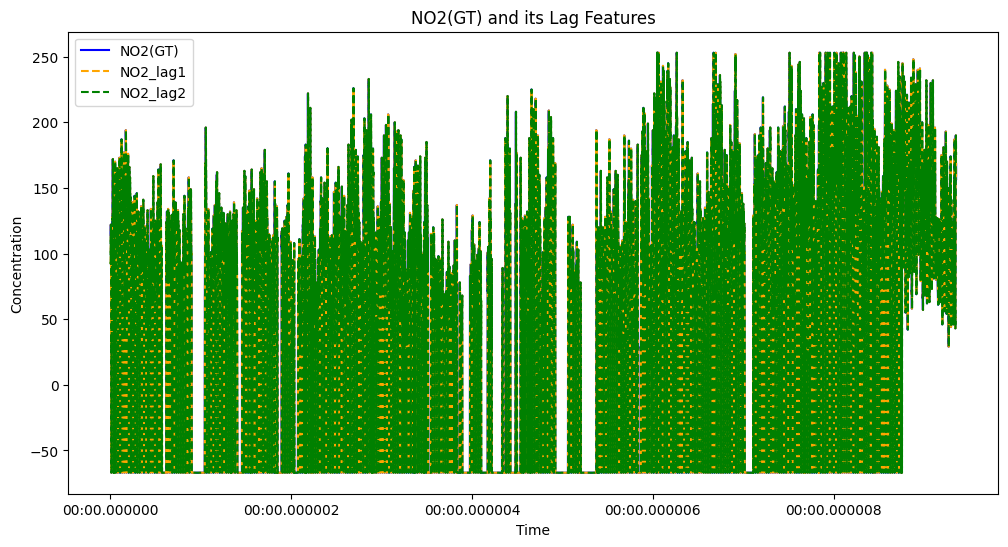

In [49]:
import matplotlib.pyplot as plt

# Plot CO(GT) with its lag features
plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'], label='CO(GT)', color='blue')
plt.plot(df['CO_lag1'], label='CO_lag1', color='orange', linestyle='--')
plt.plot(df['CO_lag2'], label='CO_lag2', color='green', linestyle='--')
plt.title('CO(GT) and its Lag Features')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Plot NO2(GT) with its lag features
plt.figure(figsize=(12, 6))
plt.plot(df['NO2(GT)'], label='NO2(GT)', color='blue')
plt.plot(df['NO2_lag1'], label='NO2_lag1', color='orange', linestyle='--')
plt.plot(df['NO2_lag2'], label='NO2_lag2', color='green', linestyle='--')
plt.title('NO2(GT) and its Lag Features')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">4. Time-Series Forecasting</h2>


  ---
- Train separate models for **CO(GT)** and **NO₂(GT)**.
- Explore the following forecasting approaches:
  - **Statistical Models**:
    - Classical models like ARIMA or SARIMA for univariate forecasting.
  - **Machine Learning Models**:
    - Use regression models trained on lag features and external predictors.
  - **Deep Learning Models**:
    - Apply LSTM, GRU, or other RNN-based models for sequence forecasting.
- Evaluate and compare the models.

<div style="background-color: #f9f9fc; color: #333366; border-radius: 12px; margin: 20px auto; padding: 20px; border: 2px solid #ff4c4c; max-width: 1000px; font-family: Arial, sans-serif; line-height: 1.6;">
  <h2 style="text-align: center; color: #333366;">Steps for SARIMA Model Preparation and Implementation</h2>

---

### Step 1: Preparing the Dataset
- **Stationarity**: Ensure that the data is stationary by performing stationarity tests (e.g., ADF test).
- **Seasonality**: Properly capture seasonality and trends in the data.
- **Train-Test Split**: Split the dataset into training and testing sets.

### Step 2: Parameter Selection for SARIMA Model
- Identify the parameters \( p, d, q, P, D, Q, s \) for the SARIMA model.

### Step 3: Build the SARIMA Model
- Fit the SARIMA model using the parameters obtained (e.g., from Auto ARIMA).

### Step 4: Forecasting
- Generate separate forecasts for **CO** and **NO2** levels.

### Step 5: Evaluation
- Evaluate the performance of the forecasts using appropriate metrics (e.g., RMSE, MAE).

In [51]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity for CO(GT)
result_co = adfuller(df['CO(GT)'])
print("CO(GT) - ADF Statistic:", result_co[0])
print("CO(GT) - p-value:", result_co[1])

# Check stationarity for NO2(GT)
result_no2 = adfuller(df['NO2(GT)'])
print("NO2(GT) - ADF Statistic:", result_no2[0])
print("NO2(GT) - p-value:", result_no2[1])


CO(GT) - ADF Statistic: -9.480388196790138
CO(GT) - p-value: 3.887056564880744e-16
NO2(GT) - ADF Statistic: -8.347870071648725
NO2(GT) - p-value: 3.0506071286120663e-13


In [52]:
# Differencing if needed
df['CO_diff'] = df['CO(GT)'].diff().dropna()
df['NO2_diff'] = df['NO2(GT)'].diff().dropna()

In [62]:
pip install --force-reinstall cython


  Using cached Cython-3.0.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
Using cached Cython-3.0.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.5 MB)
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
from pmdarima import auto_arima

# Auto ARIMA for CO(GT)
auto_arima_co = auto_arima(df['CO(GT)'], seasonal=True, m=12)
print(auto_arima_co.summary())

# Auto ARIMA for NO2(GT)
auto_arima_no2 = auto_arima(df['NO2(GT)'], seasonal=True, m=12)
print(auto_arima_no2.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject